In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
matplotlib.rcParams['font.size'] = 12

import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


According to [Newton+2019](https://arxiv.org/pdf/1906.10703.pdf), age of TOI200/DS Tuc A ~45 Myr.

In [2]:
#search by toiid
toiid=200
t = cr.Star(toiid=toiid)
t.target_coord #note distance is also known for TOIs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (354.91545833, -69.19604167, 44.0622)>

## age using gyrochronology

Available sectors: [1]
Using sector=1.
Searching lightcurvefile for TIC 410214986 (sector 1)


Text(0.5, 1.0, 'TIC 410214986 (sector 1)')

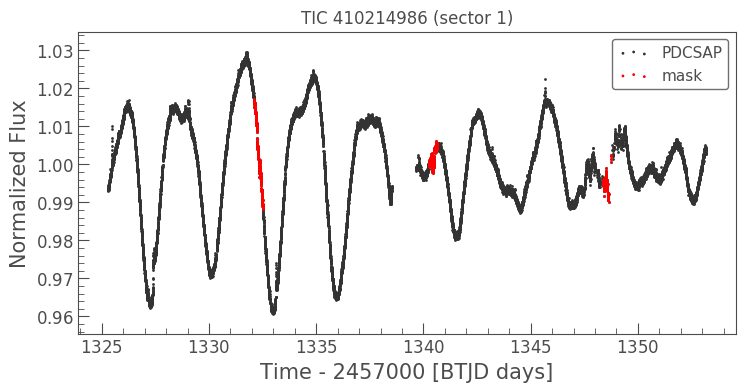

In [4]:
s = cr.ShortCadence(toiid=toiid)
lc = s.get_lc(lctype='pdcsap')
tmask = cr.get_transit_mask(lc,
                            period=s.toi_params['Period (days)'],
                            t0=s.toi_params['Epoch (BJD)']-cr.utils.TESS_TIME_OFFSET,
                            t14_hours=s.toi_params['Duration (hours)'])

ax = lc.scatter(label='PDCSAP')
lc[tmask].scatter(ax=ax, label='mask', c='r')
ax.set_title(f'TIC {s.ticid} (sector {s.sector})')

Text(0.5, 0.98, 'TIC 410214986 (sector 1)')

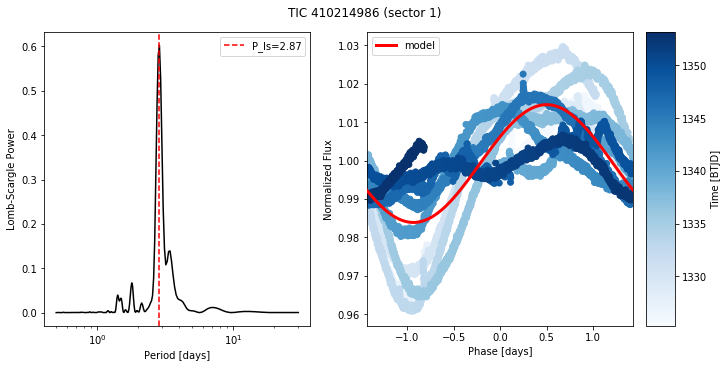

In [5]:
lc = s.lc_pdcsap.remove_outliers().normalize()[~tmask]
fig = cr.plot_lomb_scargle(lc.time, lc.flux)
fig.suptitle(f'TIC {s.ticid} (sector {s.sector})')

P=2.86+/-0.14 d


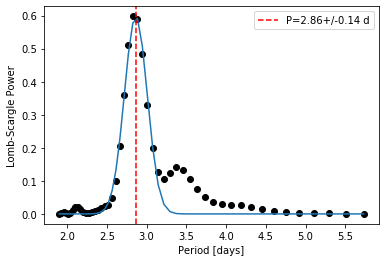

In [7]:
prot, prot_err = cr.get_rotation_period(lc, 
                       min_per=0.5, 
                       max_per=None, 
                       npoints=25, 
                       plot=True, 
                       verbose=True)

In [8]:
#get age results
age,age_plus,age_minus,samples = t.get_age(method='gyro', prot=(prot,prot_err), return_samples=True)

Querying Gaia DR2 catalog for 354.915 -69.196 within 2.0 arcsec.

Querying TIC catalog for 354.915 -69.196
            within 2.0 arcsec.

Gaia and TIC catalog cross-match succeeded.
Estimating age using gyrochronology
stellar age = 119.62 + 57.70 - 20.97 Myr


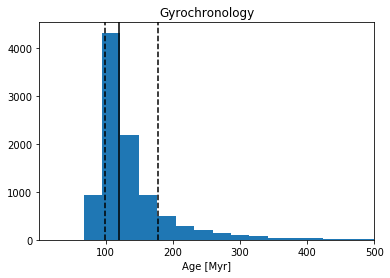

In [11]:
pl.hist(samples/1e6, bins=500);
pl.axvline((age+age_plus)/1e6, 0, 1, ls='--', c='k')
pl.axvline(age/1e6, 0, 1, ls='-', c='k')
pl.axvline((age-age_minus)/1e6, 0, 1, ls='--', c='k')
pl.title('Gyrochronology')
pl.xlabel('Age [Myr]')
pl.xlim(1,5e2);

## age using gyrochronology+isochrones

In [12]:
#first run stardate
star = t.run_stardate(prot=(prot,prot_err), mcmc_steps=5000)

Gaia and TIC catalog cross-match succeeded.
Estimating age using isochrones+gyrochronology


100%|██████████| 5000/5000 [01:17<00:00, 64.71it/s]

nsteps 5000 burnin 0


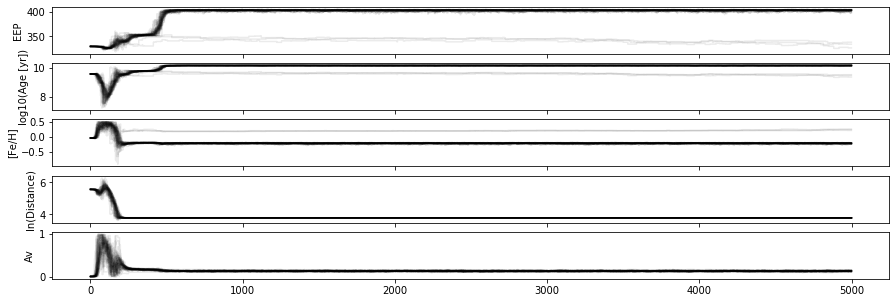

In [13]:
fig = t.plot_flatchain();

In [14]:
#get age results
burnin = 3000
age,age_plus,age_minus,samples = t.get_age(method='isochrones', return_samples=True, burnin=burnin)

stellar age = 13909.11 + 161.67 - 415.97 Myr


Text(0.5, 0, 'Age [Myr]')

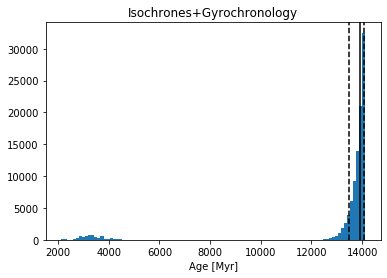

In [19]:
pl.hist(samples/1e6, bins=100);
pl.axvline((age+age_plus)/1e6, 0, 1, ls='--', c='k')
pl.axvline(age/1e6, 0, 1, ls='-', c='k')
pl.axvline((age-age_minus)/1e6, 0, 1, ls='--', c='k')
pl.title('Isochrones+Gyrochronology')
pl.xlabel('Age [Myr]')
# pl.xlim(1,5e2);

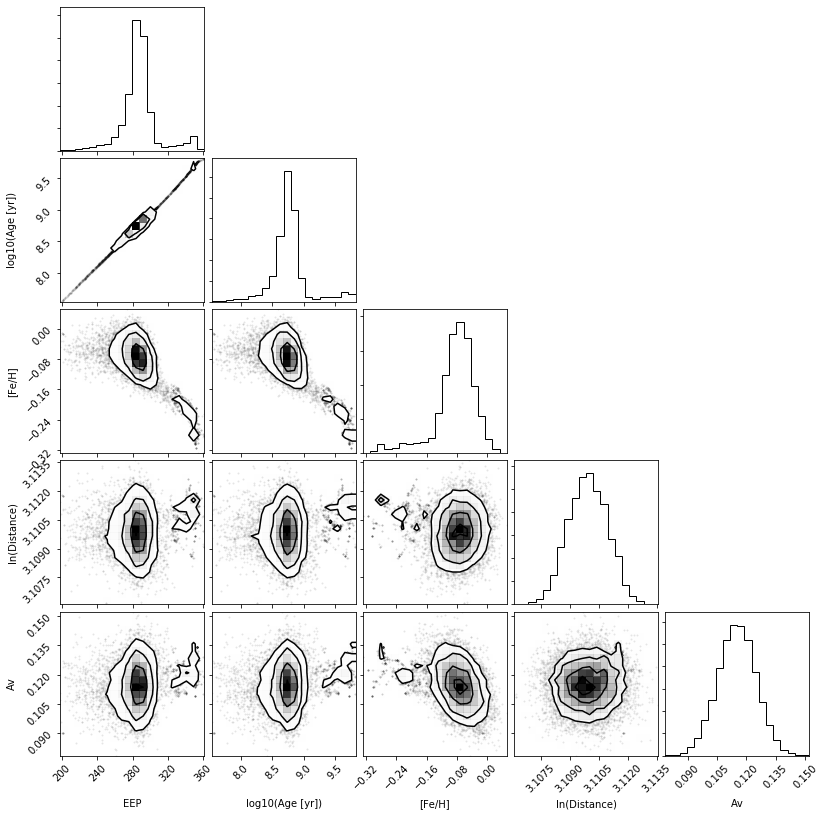

In [12]:
fig = t.plot_corner(burnin=burnin)

## spot

In [54]:
amp = (8,2)
age,age_plus,age_minus,samples = t.get_spot_age(amp=amp, nsamples=int(1e7),return_samples=True)

stellar age = 56.42 + 944160.44 - 56.42 Myr


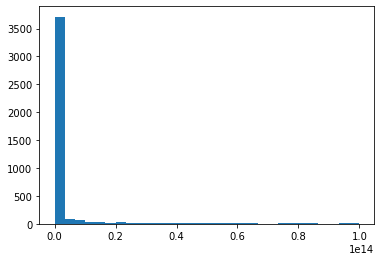

In [55]:
pl.hist(samples,30);

Text(0, 0.5, 'Smoothed Amplitude [%]')

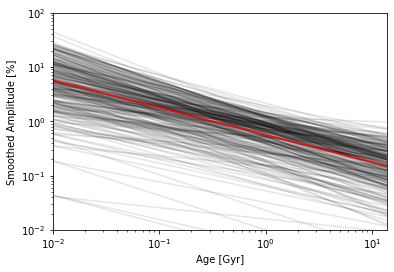

In [141]:
nsamples = int(1e4)
t = np.linspace(1e-2,14,nsamples) #Gyr
a = (0.56,0.5)
m = (-0.5,0.17)
a_s = a[0]+np.random.randn(nsamples)*a[1]
m_s = m[0]+np.random.randn(nsamples)*m[1]

def smoothed_amplitude(a,m,t):
    return a*t**m

for i in range(300):
    j = np.random.randint(0,nsamples)
    x,y = a_s[j], m_s[j]
    amp = smoothed_amplitude(x,y,t)    
    pl.loglog(t,amp,alpha=0.1,c='k')
    pl.ylim(1e-2,1e2)
    pl.xlim(1e-2,14)
pl.loglog(t,smoothed_amplitude(a[0],m[0],t),'r-')
pl.xlabel('Age [Gyr]')
pl.ylabel('Smoothed Amplitude [%]')

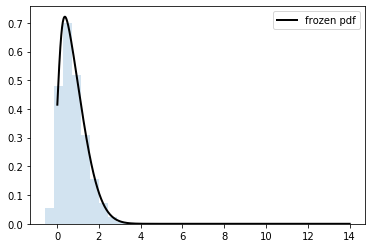

In [195]:
from scipy.stats import skewnorm

a=5
# mean, var, skew, kurt = skewnorm.stats(a, moments='mvsk')
r = skewnorm.rvs(a, size=10000)
pl.hist(r, density=True, histtype='stepfilled', alpha=0.2);

rv = skewnorm(a)
pl.plot(t, rv.pdf(t), 'k-', lw=2, label='frozen pdf')
pl.legend()

In [193]:
np.percentile(rv.pdf(t), [50,16,84])

array([1.76410580e-11, 7.29177682e-31, 6.37081935e-02])